In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
from sklearn import preprocessing
RANDOM_SEED = 42

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)
df=pd.read_csv('compas-scores-two-years.csv')

# preparing data by selecting needed colums and removing empty values
df = df[['sex', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
df = df.dropna(how='any')

# Replace text with numbers
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

#splitting and converting data to tensor
X = df[['sex','age_cat', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth

# Arrange the data : Training, Testing, Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_test.shape) +", "+ str(y_test.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))


Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..
Training	 :torch.Size([5193, 9]), torch.Size([5193])
Testing		 :torch.Size([1443, 9]), torch.Size([1443])
Validation	 :torch.Size([578, 9]), torch.Size([578])


Net(
  (fc1): Linear(in_features=9, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.689, Acc: 0.656 	|| Validation : - Loss: 0.686, Acc: 0.652
epoch {50} 	==> Train : - Loss: 0.357, Acc: 0.885 	|| Validation : - Loss: 0.386, Acc: 0.863
epoch {100} 	==> Train : - Loss: 0.287, Acc: 0.906 	|| Validation : - Loss: 0.301, Acc: 0.898
epoch {150} 	==> Train : - Loss: 0.281, Acc: 0.906 	|| Validation : - Loss: 0.297, Acc: 0.898
epoch {200} 	==> Train : - Loss: 0.278, Acc: 0.906 	|| Validation : - Loss: 0.297, Acc: 0.901
epoch {250} 	==> Train : - Loss: 0.276, Acc: 0.906 	|| Validation : - Loss: 0.296, Acc: 0.901
epoch {300} 	==> Train : - Loss: 0.275, Acc: 0.906 	|| Validation : - Loss: 0.295, Acc: 0.901
epoch {350} 	==> Train : - Loss: 0.274, Acc: 0.901 	|| Validation : - Loss: 0.294, Acc: 0.901
epoch {400} 	==> Train : - Loss: 0.273, Acc: 0.901 	|| Validation : 

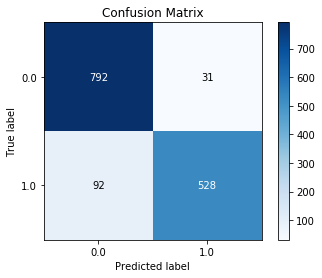

In [2]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

# criterion = torch.nn.MSELoss(reduction='sum')
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")

max_epochs = 1000
batch_size = 1000
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')

# Test the model using test set
classes = ['No Recid', 'Recid']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)